In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.layers import Dropout
import keras 

In [3]:
# Step 1: Data Preparation
# Load the data into a pandas DataFrame or read from a CSV file
data = pd.read_csv('data_cleaned.csv')  # Replace 'data.csv' with your data file path

greece_data = data.loc[data['Entity'] == 'Greece']
greece_data = greece_data.drop(['Entity', 'Continent'], axis=1).reset_index()

greece_data['Date'] = pd.to_datetime(greece_data['Date'])
greece_data.sort_values('Date', inplace=True)


specific_date = pd.to_datetime('2021-01-01')
index = greece_data[greece_data['Date'] == specific_date].index[0]


X_before = greece_data.iloc[:index].reset_index().drop(['level_0', 'index'], axis=1)
X_after = greece_data.iloc[index:].reset_index().drop(['level_0', 'index'], axis=1)


X_before['Positivity'] = (X_before['Daily cases'] / X_before['Daily tests']) * 100
X_after['Positivity'] = (X_after['Daily cases'] / X_after['Daily tests']) * 100


X_before['Positivity_3DaysLater'] = X_before['Positivity'].shift(-3)
X_after['Positivity_3DaysLater'] = X_after['Positivity'].shift(-3)


X_before = X_before[:-3]
X_after = X_after[:-3]



features = ['Daily tests', 'Daily cases']
target = 'Positivity_3DaysLater'

X_train = X_before[features]
X_test = X_after[features]
y_train = X_before[target]
y_test = X_after[target]


In [4]:
# Step 4: RNN Model Training
# Reshape the input data for LSTM model
X_train_rnn = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

model_rnn = Sequential(
    [
        LSTM(300, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(300, return_sequences=True),
        Dropout(0.2),
        LSTM(300, return_sequences=True),
        Dropout(0.2),
        LSTM(300, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ]
)

model_rnn.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate = 0.001),
    metrics="mean_absolute_percentage_error",
)

model_rnn.fit(X_train,
          y_train,
          epochs=100,
          batch_size=32,
          validation_data=(X_test, y_test))

# Step 5: SVM Model Training
# Build the SVR model
model_svm = SVR(kernel='rbf')

# Train the model
model_svm.fit(X_train, y_train)

# Step 6: Model Evaluation
# Make predictions with both models
y_pred_rnn = model_rnn.predict(X_test_rnn).flatten()
y_pred_svm = model_svm.predict(X_test)

# Evaluate the models
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
mae_rnn = mean_absolute_error(y_test, y_pred_rnn)
r2_rnn = r2_score(y_test, y_pred_rnn)

mse_svm = mean_squared_error(y_test, y_pred_svm)
mae_svm = mean_absolute_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

# Print the evaluation metrics
print("RNN Model:")
print("Mean Squared Error (MSE):", mse_rnn)
print("Mean Absolute Error (MAE):", mae_rnn)
print("R-squared (R^2) Score:", r2_rnn)

print("SVM Model:")
print("Mean Squared Error (MSE):", mse_svm)
print("Mean Absolute Error (MAE):", mae_svm)
print("R-squared (R^2) Score:", r2_svm)


2023-05-31 18:53:15.394364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-31 18:53:15.396870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-31 18:53:15.398799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-05-31 18:53:17.081467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-31 18:53:17.084012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-31 18:53:17.086455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - ETA: 0s - loss: 42.4758 - mean_absolute_percentage_error: 1009206.8750

2023-05-31 18:53:25.817831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-31 18:53:25.819584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-31 18:53:25.821376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 11s 337ms/step - loss: 42.4758 - mean_absolute_percentage_error: 1009206.8750 - val_loss: 37.2614 - val_mean_absolute_percentage_error: 110.6679
Epoch 2/100
8/8 [==============================] - 0s 44ms/step - loss: 33.4893 - mean_absolute_percentage_error: 20677438.0000 - val_loss: 34.9916 - val_mean_absolute_percentage_error: 28.6111
Epoch 3/100
8/8 [==============================] - 0s 38ms/step - loss: 33.2132 - mean_absolute_percentage_error: 8169087.0000 - val_loss: 34.3748 - val_mean_absolute_percentage_error: 66.5563
Epoch 4/100
8/8 [==============================] - 0s 38ms/step - loss: 30.8710 - mean_absolute_percentage_error: 12315491.0000 - val_loss: 38.7962 - val_mean_absolute_percentage_error: 125.1490
Epoch 5/100
8/8 [==============================] - 0s 39ms/step - loss: 28.2880 - mean_absolute_percentage_error: 6291138.5000 - val_loss: 37.2481 - val_mean_absolute_percentage_error: 110.5977
Epoch 6/100
8/8 [=======================

2023-05-31 18:53:59.292858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-31 18:53:59.295095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-31 18:53:59.296761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 2s 6ms/step
RNN Model:
Mean Squared Error (MSE): 38.02044326239551
Mean Absolute Error (MAE): 3.35195916165898
R-squared (R^2) Score: -0.11414128478648689
SVM Model:
Mean Squared Error (MSE): 34.06061790289544
Mean Absolute Error (MAE): 2.549580455950777
R-squared (R^2) Score: 0.0018964184858224487


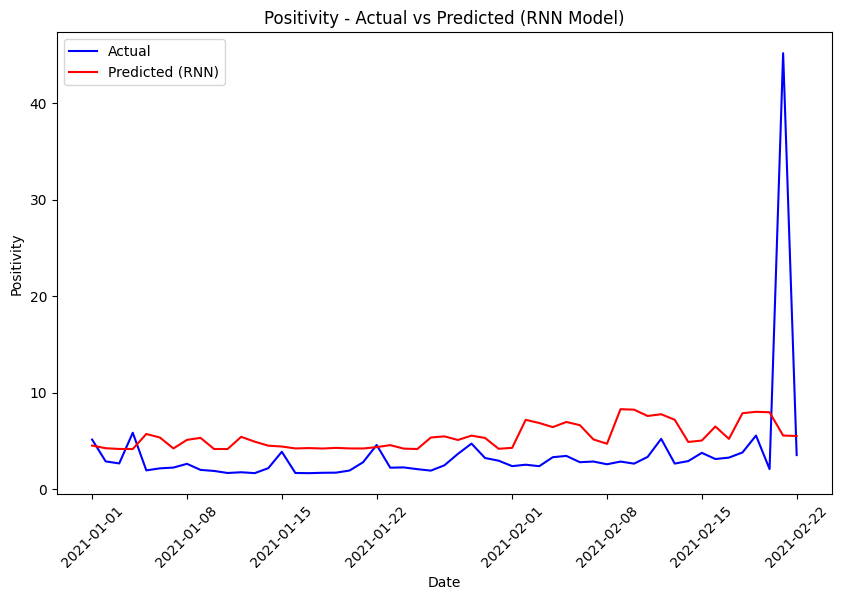

In [5]:
# print the row y_test.index[0]
rows = X_after.iloc[y_test.index]
dates = rows['Date'].values


# create a dateframe with y_test.index index y_test values and y_pred_rnn values and dates
df = pd.DataFrame({'index': y_test.index, 'y_test': y_test.values, 'y_pred_rnn': y_pred_rnn, 'dates': dates})
# sort the dataframe by index
df = df.sort_values(by=['index'])



# Plotting the predicted and actual values for RNN model
plt.figure(figsize=(10, 6))
plt.plot(df['dates'], df['y_test'], label='Actual', color='blue')
plt.plot(df['dates'], df['y_pred_rnn'], label='Predicted (RNN)', color='red')
plt.xlabel('Date')
plt.ylabel('Positivity')
plt.title('Positivity - Actual vs Predicted (RNN Model)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

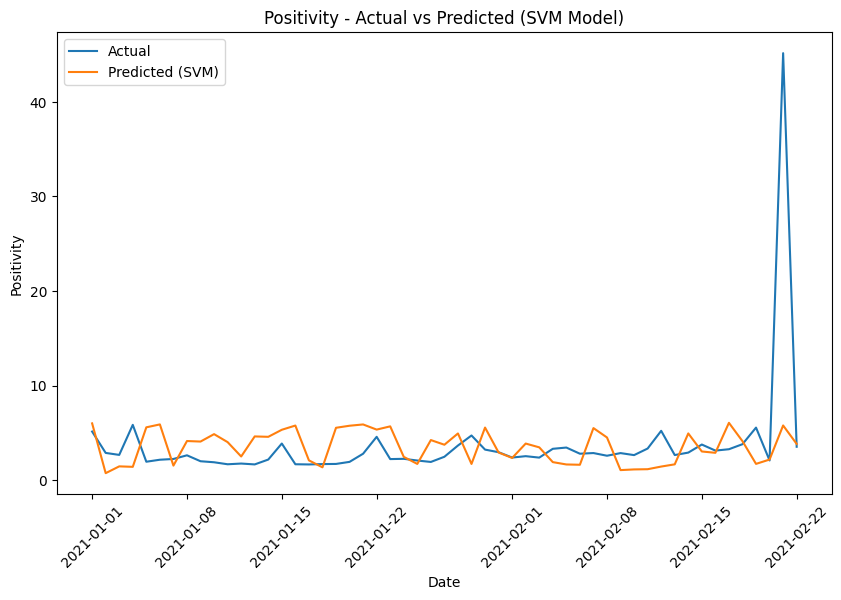

43     2.672699
44     2.931115
45     3.782864
46     3.143276
47     3.287924
48     3.820390
49     5.573350
50     2.099599
51    45.148280
52     3.548471
Name: Positivity_3DaysLater, dtype: float64

In [6]:
# create a dateframe with y_test.index index y_test values and y_pred_rnn values and dates
svm_df = pd.DataFrame({'index': y_test.index, 'y_test': y_test.values, 'y_pred_svm': y_pred_svm, 'dates': dates})
# sort the dataframe by index
svm_df = svm_df.sort_values(by=['index'])

# Plotting the predicted and actual values for SVM model
plt.figure(figsize=(10, 6))
plt.plot(svm_df['dates'],svm_df['y_test'], label='Actual')
plt.plot(svm_df['dates'],svm_df['y_pred_svm'], label='Predicted (SVM)')
plt.xlabel('Date')
plt.ylabel('Positivity')
plt.title('Positivity - Actual vs Predicted (SVM Model)')
plt.legend()
plt.xticks(rotation=45)
plt.show()